In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pathlib 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_WID, IMG_HG = 224, 224
IMG_SIZE = (IMG_WID, IMG_HG)
VAL_RATIO = 0.15
PATIENCE = 2
TRAIN_Ratio = 0.7
TEST_Ratio = 1
VAL_Ratio = 0.15
EPOCHS = 50
FIT_BATCH = 128

In [3]:
data_images = '/kaggle/input/project-images/Data/Sport Images'
data_video = '/kaggle/input/project-images/Data/Sport Videos'

## Creating the required dataset

In [4]:
def split_folders(image_path, label_count):
    dataset = tf.keras.utils.image_dataset_from_directory(image_path,labels=None,label_mode='int',color_mode='rgb',batch_size=None,image_size=IMG_SIZE,seed=20)
    dataset = dataset.map(lambda x: (x, label_count))
    total_file = len(dataset)
    train_size, val_size = int(np.ceil(total_file*TRAIN_Ratio)), int(np.ceil(total_file*VAL_Ratio))
    test_size = int(TEST_Ratio*(total_file - (train_size + val_size)))
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size + val_size).take(test_size)
    return [train, val, test]

In [5]:
classes = ['baseball','basketball','fencing','tennis','volleyball']
data_sets = []
for idx in range(len(classes)):
    data_sets.append(split_folders(data_images+'/'+classes[idx], idx))

Found 734 files belonging to 1 classes.
Found 492 files belonging to 1 classes.
Found 634 files belonging to 1 classes.
Found 715 files belonging to 1 classes.
Found 704 files belonging to 1 classes.


In [6]:
train, val, test = data_sets[0][0],data_sets[0][1],data_sets[0][2]
for t, v, tst in data_sets[1:]:
    train = train.concatenate(t)
    val = val.concatenate(v)
    test = test.concatenate(tst)

# Data Augmentation

In [7]:
image_augmentation_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
image_augmentation_rotation = tf.keras.layers.RandomRotation((-0.1, 0.3))
image_augmentation_translation = tf.keras.layers.RandomTranslation((-0.1, 0.5), (-0.2, 0.4))
image_augmentation_zoom = tf.keras.layers.RandomZoom((-0.1, 0.4))
image_augmentation_brightness = tf.keras.layers.RandomBrightness(0.6)
image_augmentation_contrast = tf.keras.layers.RandomContrast(0.3)

In [8]:
def chooseRandom(img):
    choice = [0,1]
    np.random.shuffle(choice)
    if choice == 1:
        return image_augmentation_zoom(image_augmentation_rotation(image_augmentation_brightness(image_augmentation_translation(img))))
    else:
        return image_augmentation_contrast(image_augmentation_flip(img))

In [9]:
dataset_random_augmentation = train.map(lambda i,l:(chooseRandom(i), l))
dataset_flip = train.map(lambda i,l:(image_augmentation_flip(i), l))
dataset_rotated = train.map(lambda i,l:(image_augmentation_rotation(i), l))
dataset_bright = train.map(lambda i,l:(image_augmentation_brightness(i), l))
dataset_zoomed = train.map(lambda i,l:(image_augmentation_zoom(i), l))

In [10]:
augmented_train = train.concatenate(dataset_random_augmentation)
augmented_train = augmented_train.concatenate(dataset_flip)
augmented_train = augmented_train.concatenate(dataset_bright)
augmented_train = augmented_train.concatenate(dataset_zoomed)

In [11]:
batched_augmented_train = augmented_train.batch(128, drop_remainder=True)
batched_val = val.batch(128, drop_remainder=True)
batched_test = test.batch(128, drop_remainder=True)

In [12]:
batched_augmented_train

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

In [13]:
batched_val

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

In [14]:
batched_test

<BatchDataset element_spec=(TensorSpec(shape=(128, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

# Model Creation

In [15]:
def modelCreation(base):
    for layer in base.layers:
        layer.trainable = False
    model = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(base.output)
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(32, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.2)(model)
    model = tf.keras.layers.BatchNormalization()(model)
    model_prediction = tf.keras.layers.Dense(5, activation = 'softmax')(model)
    model_final = tf.keras.Model(inputs = base.input, outputs = model_prediction)
    model_final.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model_final

In [16]:
resnet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
efficient = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
vgg = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [17]:
resnet_model = modelCreation(resnet)
efficient_model = modelCreation(efficient)
vgg_model = modelCreation(vgg)

In [18]:
# Early stop and restore weight from best model, min validation loss
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, mode='min', restore_best_weights=True)

In [19]:
resnet_history = resnet_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50
89/89 [==============================] - 73s 703ms/step - loss: 1.7691 - accuracy: 0.2116 - val_loss: 1.3403 - val_accuracy: 0.4115
Epoch 2/50
89/89 [==============================] - 57s 638ms/step - loss: 1.6573 - accuracy: 0.2388 - val_loss: 1.2482 - val_accuracy: 0.7031
Epoch 3/50
89/89 [==============================] - 58s 644ms/step - loss: 1.6267 - accuracy: 0.2539 - val_loss: 1.1770 - val_accuracy: 0.8464
Epoch 4/50
89/89 [==============================] - 59s 652ms/step - loss: 1.6092 - accuracy: 0.2602 - val_loss: 1.1617 - val_accuracy: 0.8464
Epoch 5/50
89/89 [==============================] - 58s 641ms/step - loss: 1.5988 - accuracy: 0.2747 - val_loss: 1.1445 - val_accuracy: 0.8906
Epoch 6/50
89/89 [==============================] - 58s 643ms/step - loss: 1.5935 - accuracy: 0.2806 - val_loss: 1.1456 - val_accuracy: 0.8802
Epoch 7/50
89/89 [==============================] - 58s 647ms/step - loss: 1.5864 - accuracy: 0.2910 - val_loss: 1.1682 - val_accuracy: 0.8411

In [20]:
efficient_history = efficient_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50


2023-05-09 09:02:52.148230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


89/89 [==============================] - 62s 627ms/step - loss: 1.8112 - accuracy: 0.2287 - val_loss: 0.9164 - val_accuracy: 0.7943
Epoch 2/50
89/89 [==============================] - 54s 599ms/step - loss: 1.6707 - accuracy: 0.2560 - val_loss: 1.0094 - val_accuracy: 0.8750
Epoch 3/50
89/89 [==============================] - 55s 609ms/step - loss: 1.6349 - accuracy: 0.2725 - val_loss: 1.0202 - val_accuracy: 0.9453
Epoch 3: early stopping


In [21]:
vgg_history = vgg_model.fit(batched_augmented_train, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_val)

Epoch 1/50
89/89 [==============================] - 72s 670ms/step - loss: 1.7843 - accuracy: 0.2108 - val_loss: 1.1827 - val_accuracy: 0.5729
Epoch 2/50
89/89 [==============================] - 61s 680ms/step - loss: 1.6472 - accuracy: 0.2258 - val_loss: 1.2375 - val_accuracy: 0.7161
Epoch 3/50
89/89 [==============================] - 61s 672ms/step - loss: 1.6218 - accuracy: 0.2403 - val_loss: 1.2183 - val_accuracy: 0.7839
Epoch 3: early stopping


# Model Evaluation

In [22]:
def plotLossVSEpoch(model_history, model):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('{} Loss vs Epoch'.format(model))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

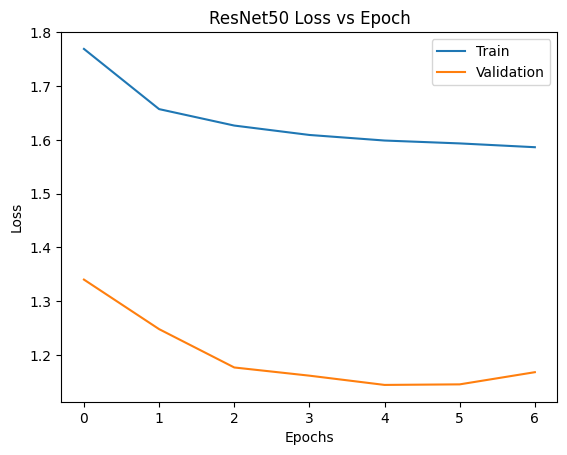

In [23]:
plotLossVSEpoch(resnet_history, 'ResNet50')

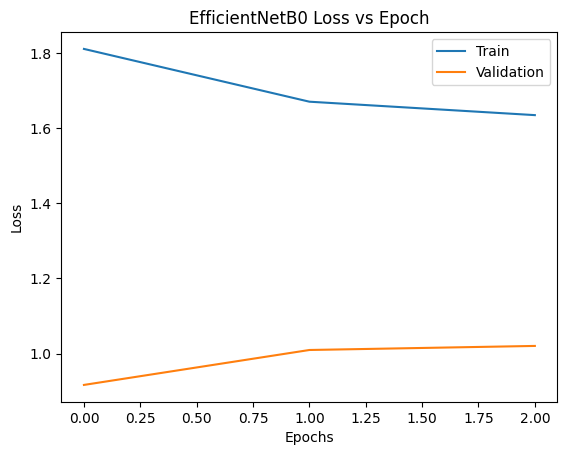

In [24]:
plotLossVSEpoch(efficient_history, 'EfficientNetB0')

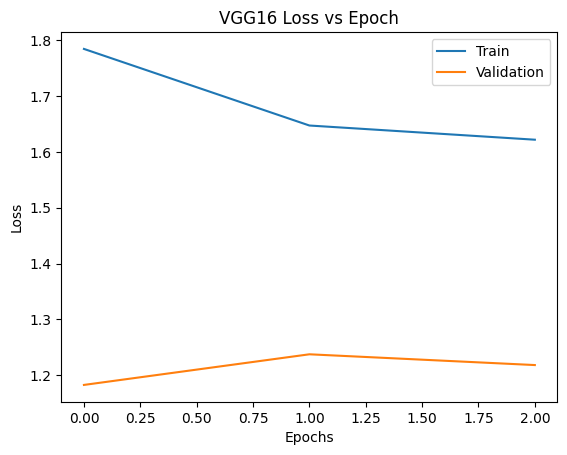

In [25]:
plotLossVSEpoch(vgg_history, 'VGG16')

# Predictions

#### Train

In [26]:
train_resnet_probabilities = resnet_model.predict(batched_augmented_train)
train_efficient_probabilities = efficient_model.predict(batched_augmented_train)
train_vgg_probabilities = vgg_model.predict(batched_augmented_train)

# Pick class with highest probabilty
train_resnet_prediction = np.argmax(train_resnet_probabilities, axis=1)
train_efficient_prediction = np.argmax(train_efficient_probabilities, axis=1)
train_vgg_prediction = np.argmax(train_vgg_probabilities, axis=1)

89/89 [==============================] - 55s 609ms/step


#### Test

In [27]:
test_resnet_probabilities = resnet_model.predict(batched_test)
test_efficient_probabilities = efficient_model.predict(batched_test)
test_vgg_probabilities = vgg_model.predict(batched_test)

# Pick class with highest probabilty
test_resnet_prediction = np.argmax(test_resnet_probabilities, axis=1)
test_efficient_prediction = np.argmax(test_efficient_probabilities, axis=1)
test_vgg_prediction = np.argmax(test_vgg_probabilities, axis=1)

3/3 [==============================] - 5s 2s/step


### Analysis of Image Models

All methods below from: 
https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification

In [28]:
def findaccuracy(y_true, y_pred):
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:            
            correct_predictions += 1
    return correct_predictions / len(y_true)

In [29]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):
    tp = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):    
    tn = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):    
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1            
    return fp

def false_negative(y_true, y_pred):
    fn = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1            
    return fn
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize precision to 0
    precision = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
    # calculate and return average precision over all classes
    precision /= num_classes
    return precision

In [30]:
def macro_recall(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize recall to 0
    recall = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # keep adding recall for all classes
        recall += temp_recall
    # calculate and return average recall over all classes
    recall /= num_classes
    return recall

In [31]:
def macro_f1(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize f1 to 0
    f1 = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        # keep adding f1 score for all classes
        f1 += temp_f1
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    return f1

In [32]:

def printResults(model_name, y_true, y_prediction):
    print("Results for model {}".format(model_name))
    # Calculate the confusion matrix
    cm = confusion_matrix( y_true, y_prediction)
    print("Confusion Matrix:\n", cm)

    precision = macro_precision( y_true, y_prediction)
    recall = macro_recall( y_true, y_prediction)
    accuracy = findaccuracy( y_true, y_prediction)
    f1 = macro_f1( y_true, y_prediction)

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

In [33]:
testing_labels = []
for img, label in (batched_test.take(len(batched_test))):
    testing_labels += list(label.numpy())
testing_labels = np.array(testing_labels)

training_labels = []
for img, label in (batched_augmented_train.take(len(batched_augmented_train))):
    training_labels += list(label.numpy())
training_labels = np.array(training_labels)

#### Train 

In [34]:
printResults('ResNet50', training_labels, train_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[1923  116  142  357   32]
 [   5 1670    9   14   27]
 [   9   20 2062   33   96]
 [ 181  148   70 2056   50]
 [  12  404  106   37 1813]]
Precision: 0.8391938387043817
Recall: 0.846057234931067
Accuracy: 0.8360252808988764
F1 Score: 0.8358263466039271


In [35]:
printResults('EfficientNetB0', training_labels, train_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[2190  158  119   97    6]
 [  14 1675   12   20    4]
 [ 166   66 1905   70   13]
 [ 612  405  201 1246   41]
 [  30 1675  214   89  364]]
Precision: 0.7188824801363274
Recall: 0.6664249730145773
Accuracy: 0.6478230337078652
F1 Score: 0.6132928214057373


In [36]:
printResults('VGG16', training_labels, train_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[ 811  213   57 1319  170]
 [  18 1262    8  329  108]
 [ 157  113  998  601  351]
 [ 225  314   79 1760  127]
 [  59  478  123  384 1328]]
Precision: 0.5991282089365557
Recall: 0.5518335713289599
Accuracy: 0.5406425561797753
F1 Score: 0.5432673659118464


#### Test

In [37]:
printResults('ResNet50', testing_labels, test_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[88  3  7  9  2]
 [ 0 71  0  0  2]
 [ 0  1 92  0  1]
 [ 8  3  1 93  1]
 [ 0  1  0  0  1]]
Precision: 0.7580045266298658
Recall: 0.8272047589339534
Accuracy: 0.8984375
F1 Score: 0.7715302561460845


In [38]:
printResults('EfficientNetB0', testing_labels, test_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[102   5   2   0   0]
 [  0  72   0   1   0]
 [  7   2  83   2   0]
 [ 21  17   6  62   0]
 [  0   1   0   0   1]]
Precision: 0.8785632906804628
Recall: 0.7779930566302065
Accuracy: 0.8333333333333334
F1 Score: 0.7979445180406661


In [39]:
printResults('VGG16', testing_labels, test_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[35  7  3 62  2]
 [ 1 55  0 15  2]
 [ 4  1 54 28  7]
 [16 11  3 75  1]
 [ 0  0  1  0  1]]
Precision: 0.5494157689047175
Recall: 0.5713081107660334
Accuracy: 0.5729166666666666
F1 Score: 0.5054245252416285


### Video Analysis

##### Retrain

In [40]:
vide_resnet_history = resnet_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 10s 4s/step - loss: 1.3571 - accuracy: 0.5260 - val_loss: 1.1355 - val_accuracy: 0.8984
Epoch 2/50
3/3 [==============================] - 10s 4s/step - loss: 1.3434 - accuracy: 0.5807 - val_loss: 1.1259 - val_accuracy: 0.9010
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 1.3138 - accuracy: 0.5599 - val_loss: 1.1047 - val_accuracy: 0.8828
Epoch 4/50
3/3 [==============================] - 10s 4s/step - loss: 1.2888 - accuracy: 0.5625 - val_loss: 1.0399 - val_accuracy: 0.8932
Epoch 5/50
3/3 [==============================] - 11s 4s/step - loss: 1.2657 - accuracy: 0.5833 - val_loss: 0.9726 - val_accuracy: 0.9089
Epoch 6/50
3/3 [==============================] - 10s 4s/step - loss: 1.2421 - accuracy: 0.5755 - val_loss: 0.9097 - val_accuracy: 0.9062
Epoch 7/50
3/3 [==============================] - 10s 4s/step - loss: 1.2078 - accuracy: 0.6042 - val_loss: 0.9219 - val_accuracy: 0.8620
Epoch 8/50
3/3 [==================

In [41]:
vide_efficient_history = efficient_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 10s 4s/step - loss: 1.4603 - accuracy: 0.4193 - val_loss: 0.8530 - val_accuracy: 0.8359
Epoch 2/50
3/3 [==============================] - 10s 4s/step - loss: 1.3931 - accuracy: 0.4505 - val_loss: 0.8310 - val_accuracy: 0.8281
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 1.3205 - accuracy: 0.4922 - val_loss: 0.6953 - val_accuracy: 0.8906
Epoch 4/50
3/3 [==============================] - 10s 4s/step - loss: 1.2695 - accuracy: 0.4896 - val_loss: 0.5957 - val_accuracy: 0.9193
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.2466 - accuracy: 0.5599 - val_loss: 0.5248 - val_accuracy: 0.9297
Epoch 6/50
3/3 [==============================] - 10s 4s/step - loss: 1.1869 - accuracy: 0.5573 - val_loss: 0.5012 - val_accuracy: 0.9193
Epoch 7/50
3/3 [==============================] - 10s 4s/step - loss: 1.1214 - accuracy: 0.5443 - val_loss: 0.4416 - val_accuracy: 0.9375
Epoch 8/50
3/3 [==================

In [42]:
vide_vgg_history = vgg_model.fit(batched_val, epochs=EPOCHS, batch_size=FIT_BATCH, callbacks=[early_stopper], verbose=1, validation_data=batched_test)

Epoch 1/50
3/3 [==============================] - 10s 4s/step - loss: 1.4928 - accuracy: 0.3203 - val_loss: 1.1713 - val_accuracy: 0.5938
Epoch 2/50
3/3 [==============================] - 11s 4s/step - loss: 1.4865 - accuracy: 0.3307 - val_loss: 1.0999 - val_accuracy: 0.6797
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 1.4399 - accuracy: 0.4167 - val_loss: 1.0184 - val_accuracy: 0.7083
Epoch 4/50
3/3 [==============================] - 10s 4s/step - loss: 1.3977 - accuracy: 0.4401 - val_loss: 1.0327 - val_accuracy: 0.7214
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.3764 - accuracy: 0.4557 - val_loss: 1.0427 - val_accuracy: 0.6953
Epoch 5: early stopping


#### Analysis

In [43]:
frames_split = 100

def preprocess_frame(img):
    img = cv2.resize(img, (IMG_WID, IMG_HG))
    img = np.expand_dims(img, axis=0)
    return img

In [44]:
def getFilesLabels():
    directory_video_Files = pathlib.Path('/kaggle/input/project-images/Data/Sport Videos')
    video_file_paths = []
    video_file_labels = []
    folder_to_class = {'BaseballPitch':0,'Basketball':1,'Fencing':2,'TennisSwing':3,'VolleyballSpiking':4}
    for video_path in directory_video_Files.glob('**/*.avi'):
        file_folder_name = os.path.basename(os.path.dirname(video_path)).split('/')[-1]
        video_file_labels.append(folder_to_class[file_folder_name])
        video_file_paths.append(str(video_path))
    return video_file_paths, video_file_labels

In [45]:
file_paths, y_true = getFilesLabels()

In [46]:
def videoPrediction(path):
    resnet_model_prediction = []
    efficient_model_prediction = [] 
    vgg_model_prediction = []
    # Verify file type
    if str(path)[-4:] == '.avi':
        picked_frames =[]
        cap = cv2.VideoCapture(str(path))
        video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        success = cap.grab()
        while success:
            if (len(picked_frames) < int(frames_split) or (len(picked_frames)/video_length) < 0.6):
                success, img = cap.retrieve()
                frame = preprocess_frame(img) # Frame as input to prediction
                resnet_model_prediction.append(resnet_model.predict(frame, verbose=0))
                efficient_model_prediction.append(efficient_model.predict(frame,verbose=0))
                vgg_model_prediction.append(vgg_model.predict(frame,verbose=0))
                success = cap.grab()
        cap.release()
    resnet_prediction = np.argmax(np.mean(resnet_model_prediction, axis=0)) 
    efficient_prediction = np.argmax(np.mean(efficient_model_prediction, axis=0))
    vgg_prediction = np.argmax(np.mean(vgg_model_prediction, axis=0)) 
    return resnet_prediction,efficient_prediction,vgg_prediction

In [47]:
predicted_list = list(map(videoPrediction, tqdm(y_true)))

  0%|          | 0/681 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 681/681 [00:00<00:00, 20466.91it/s]


In [48]:
columnwise_predictions = list(zip(*predicted_list))
prediction_resnet_model = columnwise_predictions[0]
prediction_efficient__model = columnwise_predictions[1]
prediction_vgg_model  = columnwise_predictions[2]

In [49]:
printResults('ResNet50', y_true, prediction_resnet_model)

Results for model ResNet50
Confusion Matrix:
 [[150   0   0   0   0]
 [137   0   0   0   0]
 [111   0   0   0   0]
 [167   0   0   0   0]
 [116   0   0   0   0]]
Precision: 0.04405286337143486
Recall: 0.19999999866666668
Accuracy: 0.22026431718061673
F1 Score: 0.07220210672197439


In [50]:
printResults('EfficientNetB0', y_true, prediction_efficient__model)

Results for model EfficientNetB0
Confusion Matrix:
 [[150   0   0   0   0]
 [137   0   0   0   0]
 [111   0   0   0   0]
 [167   0   0   0   0]
 [116   0   0   0   0]]
Precision: 0.04405286337143486
Recall: 0.19999999866666668
Accuracy: 0.22026431718061673
F1 Score: 0.07220210672197439


In [51]:
printResults('VGG16', y_true, prediction_vgg_model)

Results for model VGG16
Confusion Matrix:
 [[150   0   0   0   0]
 [137   0   0   0   0]
 [111   0   0   0   0]
 [167   0   0   0   0]
 [116   0   0   0   0]]
Precision: 0.04405286337143486
Recall: 0.19999999866666668
Accuracy: 0.22026431718061673
F1 Score: 0.07220210672197439


### References

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take

https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification